In [1]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch
torch.manual_seed(42)

In [2]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'all_data-7' # data
args.root_path = './ETDataset/ETT-small/' # root path of data file
args.data_path = 'all_data-7.csv' # data file
args.features = 'MS' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'LNG_future' # target feature in S or MS task
args.freq = 'd' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 256 # input sequence length of Informer encoder
args.label_len = 128 # start token length of Informer decoder
args.pred_len = 7 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 21 # encoder input size
args.dec_in = 21 # decoder input size
args.c_out = 1 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = False
args.padding = 0
args.do_predict =True
args.batch_size = 32 
args.learning_rate = 0.00005
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training
args.num_workers = 0
args.itr = 1
args.train_epochs = 10
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'


In [3]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

args.detail_freq = args.freq
args.freq = args.freq[-1:]
Exp = Exp_Informer
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
   
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_all_data-7_ftMS_sl256_ll128_pl7_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxFalse_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 439
val 2
test 39
Epoch: 1 cost time: 14.240089416503906
Epoch: 1, Steps: 13 | Train Loss: 3.5874873 Vali Loss: nan Test Loss: 0.2173532
Validation loss decreased (inf --> nan).  Saving model ...
Updating learning rate to 5e-05
Epoch: 2 cost time: 2.5869052410125732
Epoch: 2, Steps: 13 | Train Loss: 0.7308257 Vali Loss: nan Test Loss: 0.5746980
Validation loss decreased (nan --> nan).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 3 cost time: 2.7189602851867676
Epoch: 3, Steps: 13 | Train Loss: 0.5599492 Vali Loss: nan Test Loss: 0.0696335
Validation loss decreased (nan --> nan).  Saving model ...
Updating learning rate to 1.25e-05
Epoch: 4 cost time: 2.748540163040161
Epoch: 4, Steps: 13 | Train Loss: 0.3796332 Vali Loss: nan Test Loss: 0.3046703
Validation loss decreased (nan --> nan).  Saving mo

# Prediction

Use GPU: cuda:0
pred 1


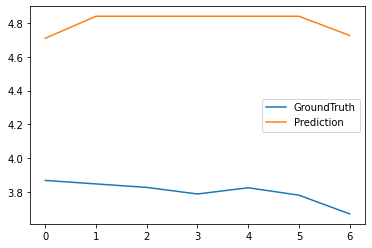

In [4]:
exp = Exp(args)
exp.predict(setting, True)
import numpy as np
import matplotlib.pyplot as plt
preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')
plt.figure()
plt.plot(trues[0,:,0], label='GroundTruth')
plt.plot(preds[0,:,0], label='Prediction')
plt.legend()
plt.show()

In [5]:
prediction = np.load('./results/'+setting+'/real_prediction.npy')
prediction[0,:,0]

array([4.751821 , 4.797426 , 4.797426 , 4.797426 , 4.797426 , 4.7974267,
       4.753399 ], dtype=float32)

In [6]:
import pandas as pd
df2 = pd.read_csv('./ETDataset/ETT-small/all_data.csv')
df2_list  = df2['LNG_future'].tolist()
import pandas as pd
df1 = pd.read_csv('./ETDataset/ETT-small/all_data-7.csv')
df1_list  = df1['LNG_future'].tolist()
df1_list = df1_list + prediction[0,:,0].tolist()

In [7]:
len(df1_list[730:])

31

In [20]:
dates = ['01-01-2022'
,'02-01-2022'
,'03-01-2022'
,'04-01-2022'
,'05-01-2022'
,'06-01-2022'
,'07-01-2022'
,'08-01-2022'
,'09-01-2022'
,'10-01-2022'
,'11-01-2022'
,'12-01-2022'
,'13-01-2022'
,'14-01-2022'
,'15-01-2022'
,'16-01-2022'
,'17-01-2022'
,'18-01-2022'
,'19-01-2022'
,'20-01-2022'
,'21-01-2022'
,'22-01-2022'
,'23-01-2022'
,'24-01-2022'
,'25-01-2022'
,'26-01-2022'
,'27-01-2022'
,'28-01-2022'
,'29-01-2022'
,'30-01-2022'
,'31-01-2022']


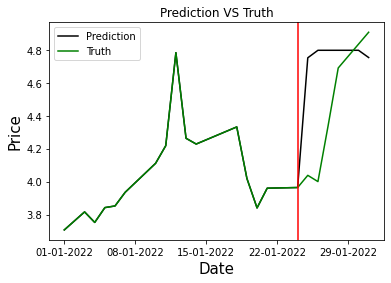

In [21]:

fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(dates,df1_list[730:],label='Prediction',color = 'black')  # Plot some data on the axes.
ax.plot(dates,df2_list[730:], label='Truth',color = 'green')  # Plot more data on the axes...
import matplotlib.ticker as mticker
ax.xaxis.set_major_locator(mticker.MultipleLocator(7))
plt.axvline(x='24-01-2022',color ='red')
ax.set_xlabel('Date',size = 15)  # Add an x-label to the axes.
ax.set_ylabel('Price',size = 15)  # Add a y-label to the axes.
ax.set_title("Prediction VS Truth")  # Add a title to the axes.
ax.legend()  # Add a legend.

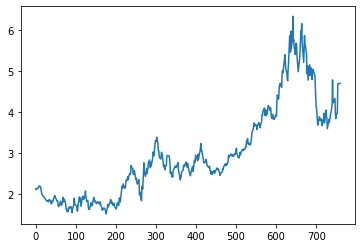

In [ ]:
plt.figure()
plt.plot(df1_list)
plt.show()

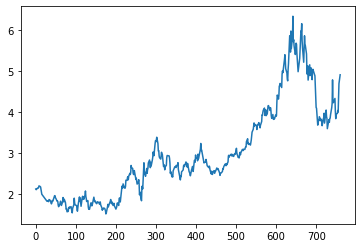

In [ ]:
plt.figure()
plt.plot(df2_list)
plt.show()